# DQN Part2

- 발표자 : 최찬혁

This code is a code that applies Dueling DQN algorithms to environment "Cartpole-v0" from OpenAI gym.

## Preliminary

- State-value function($v_{\pi} \left( s \right)$) : Expected return starting from state $s$, and then following policy $\pi$.

$\quad v_{\pi} \left( s \right) = \mathbb{E} _{\pi} \left[ G_{t} | S_{t} = s \right]$

- Action-value function($q_{\pi} \left( s, a \right)$) : Expected return starting from state $s$, taking action $a$, and following policy $\pi$.

$\quad q_{\pi} \left( s, a \right) = \mathbb{E} _{\pi} \left[ G_{t} | S_{t} = s, A_{t} = a \right]$

- Advantage function($A_{\pi} \left( s, a \right)$) : The difference of Action-value function and State-value function.

$\quad A_{\pi} \left( s, a \right) = q_{\pi} \left( s, a \right) - v_{\pi} \left( s \right)$


## Key idea1 (DQN vs Dueling DQN)
In DQN or Double DQN algorithm, we make 1 neural network to approximate to **action-value function**.

In Dueling DQN algorithm, we make 2 neural networks to approximate to **state-value function** and **advantage function**.

![compare](./Dueling_DQN_Algorithm.JPG)

## Key idea2 (Identifiability issue)
Aggregating module $Q \left( s,a;\theta , \alpha , \beta \right) = V \left( s; \theta , \beta \right) + A \left( s,a; \theta , \alpha \right)$ is **unidentifiable** in the sense that given $Q$ we can't recover $V$ and $A$ uniquely.

We can't say that $V \left( s; \theta , \beta \right)$ and $A \left( s,a; \theta , \alpha \right)$ are good estimators of $V \left( s\right)$ and $A \left( s,a \right)$ respectively.

To address this issue, we can force $A \left( s,a; \theta , \alpha \right)$ to have zero advantage at chosen optimal(best) action by implementing.

$\quad Q \left( s,a;\theta , \alpha , \beta \right) = V \left( s; \theta , \beta \right) + \left[ A \left( s,a; \theta , \alpha \right) - \underset{a'}{\max} A \left( s,a'; \theta , \alpha \right) \right]$

In practical reason, we instead use above aggregating module as follows

$\quad Q \left( s,a;\theta , \alpha , \beta \right) = V \left( s; \theta , \beta \right) + \left[ A \left( s,a; \theta , \alpha \right) - \frac{1}{\left| \mathcal{A} \right|} \sum_{a'}^{}A \left( s,a'; \theta , \alpha \right) \right]$

In [1]:
!pip install gym --upgrade

In [2]:
import gym
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Add, Dense, Input, Lambda
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

import random
from collections import deque

In [3]:
learning_rate = 0.001
GAMMA = 0.95
epsilon = 1.0

buffer_capacity = 1000
n_sample = 32
synchronize_period = 20 # The period of reset target network to behavior network

In [4]:
env1 = gym.make("CartPole-v1")

In [5]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def store(self, state, action, reward, next_state, done):
        self.buffer.append([state, action, reward, next_state, done])

    def sample(self):
        sample = random.sample(self.buffer, n_sample)
        states, actions, rewards, next_states, done = map(np.asarray, zip(*sample))
        states = np.array(states).reshape(n_sample, -1)
        next_states = np.array(next_states).reshape(n_sample, -1)
        return states, actions, rewards, next_states, done

    def size(self):
        return len(self.buffer)

In [6]:
class DuelingDQN:
    def __init__(self, state_dim, aciton_dim):
        self.state_dim = state_dim
        self.action_dim = aciton_dim
        self.epsilon = epsilon

        self.model = self.nn_model()

    def nn_model(self):
        state_input = Input((self.state_dim,))
        backbone_1 = Dense(8, kernel_initializer = tf.keras.initializers.HeNormal(),activation="relu")(state_input)
        backbone_2 = Dense(8, kernel_initializer = tf.keras.initializers.HeNormal(),activation="relu")(backbone_1)
        value_output = Dense(1,kernel_initializer = tf.keras.initializers.HeNormal(),)(backbone_2)
        advantage = Dense(self.action_dim,kernel_initializer = tf.keras.initializers.HeNormal())(backbone_2)
        advantage_output = Lambda(lambda a: a[:, :] - K.mean(a[:, :], axis=1, keepdims=True),output_shape=(self.action_dim,))(advantage)
        output = Add()([value_output, advantage_output])
        model = tf.keras.Model(state_input, output)
        model.compile(loss=tf.keras.losses.Huber(delta=1.0), optimizer=Adam(learning_rate))

        return model

    def predict(self, state):
        return self.model.predict(state, verbose=0)

    def get_action(self, state):
        state = np.reshape(state, [1, self.state_dim])
        #self.epsilon *= epsilon_decay
        #self.epsilon = max(self.epsilon, epsilon_min)
        q_value = self.predict(state)[0]
        if np.random.random() < self.epsilon:
            return random.randint(0, self.action_dim - 1)
        return np.argmax(q_value)

    def train(self, states, targets):
        self.model.fit(states, targets, epochs=1, verbose=0)

In [7]:
class Agent:
    def __init__(self, env):
        self.env = env
        self.state_dim = self.env.observation_space.shape[0]
        self.action_dim = self.env.action_space.n

        self.model = DuelingDQN(self.state_dim, self.action_dim)        # Behavior network
        self.target_model = DuelingDQN(self.state_dim, self.action_dim) # Target network
        self.update_target()

        self.buffer = ReplayBuffer(buffer_capacity)

    def update_target(self):
        weights = self.model.model.get_weights()
        self.target_model.model.set_weights(weights)

    def replay_experience(self):
        states, actions, rewards, next_states, done = self.buffer.sample()
        targets = self.model.model.predict(states,verbose=0)
        next_q_values = self.target_model.predict(next_states).max(axis=1)
        targets[range(n_sample), actions] = (
            rewards + (1 - done) * next_q_values * GAMMA
        )
        self.model.train(states, targets)

    def train(self, max_episodes=1000):
        episode_rewards = []
        timestep = 0
        for ep in range(max_episodes):
            done, episode_reward = False, 0
            self.model.epsilon = 1.0/(1.0+(ep*0.1))
            observation, _ = self.env.reset()
            while not done:
                action = self.model.get_action(observation)
                timestep = timestep + 1
                next_observation, reward, terminated, truncated, _ = self.env.step(action)
                done = terminated or truncated
                self.buffer.store(
                    observation, action, reward*0.1, next_observation, done
                )
                episode_reward += reward
                observation = next_observation
            
                if self.buffer.size() >= n_sample:
                    self.replay_experience()
            
                if (timestep % synchronize_period) == 0:
                    self.update_target()
            print(f"Episode#{ep} Reward:{episode_reward}")
            
            episode_rewards.append(episode_reward)
        
        plt.plot(episode_rewards)
        plt.show()
        return episode_rewards

In [8]:
agent1 = Agent(env1)

Episode#0 Reward:12.0
Episode#1 Reward:11.0
Episode#2 Reward:9.0
Episode#3 Reward:16.0
Episode#4 Reward:26.0
Episode#5 Reward:22.0
Episode#6 Reward:12.0
Episode#7 Reward:36.0
Episode#8 Reward:16.0
Episode#9 Reward:10.0
Episode#10 Reward:11.0
Episode#11 Reward:16.0
Episode#12 Reward:11.0
Episode#13 Reward:10.0
Episode#14 Reward:13.0
Episode#15 Reward:10.0
Episode#16 Reward:16.0
Episode#17 Reward:8.0
Episode#18 Reward:9.0
Episode#19 Reward:10.0
Episode#20 Reward:9.0
Episode#21 Reward:9.0
Episode#22 Reward:9.0
Episode#23 Reward:10.0
Episode#24 Reward:11.0
Episode#25 Reward:10.0
Episode#26 Reward:11.0
Episode#27 Reward:17.0
Episode#28 Reward:13.0
Episode#29 Reward:8.0
Episode#30 Reward:10.0
Episode#31 Reward:14.0
Episode#32 Reward:10.0
Episode#33 Reward:15.0
Episode#34 Reward:10.0
Episode#35 Reward:11.0
Episode#36 Reward:12.0
Episode#37 Reward:15.0
Episode#38 Reward:107.0
Episode#39 Reward:15.0
Episode#40 Reward:192.0
Episode#41 Reward:205.0
Episode#42 Reward:97.0
Episode#43 Reward:40.0
Ep

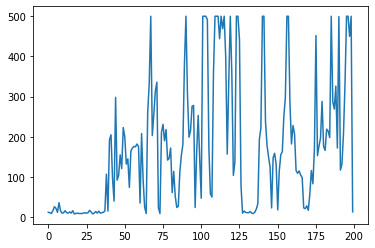

In [9]:
ep_rewards_DuelDQN = agent1.train(max_episodes=200)

In [12]:
np.save("DuelDQN-result.npy", np.array(ep_rewards_DuelDQN))